# Molecule Ring & Close Atoms Lifting Tutorial

***
This notebook imports QM9 dataset and applies a lifting from a graph molecular representation to a combinatorial complex. Then, a neural network is run using the loaded data.

We implement a lifting from a molecule graph to a combinatorial complex based on two points:
- The ring information of the molecule. Rings will be represented as 2-cells in the combinatorial complex.
- The distance between atoms in the molecule. Distances between atoms will be computed. If the atoms are under a predefined threshold, they will be considered as close and groupped together. This clusters will be introduced as hyperedges in the combinatorial complex.

Additionally, attributes inspired by those used in [(Battiloro et al., 2024)](https://arxiv.org/abs/2405.15429) are incorporated into the elements, enhancing the representation of the molecule.
The attributes are:
- **Node**: Atom type, atomic number, and chirality.
- **Edge**: Bond type, conjugation and stereochemistry.
- **Close atoms groups**: Conjugation, hydrophobicity, electrophilicity, nucleophilicity, and polarity.
- **Rings**: Ring size, aromaticity, heteroatoms, saturation, hydrophobicity, electrophilicity, nucleophilicity, and polarity.

The notebook is divided into sections:

- [Loading the dataset](#loading-the-dataset) loads the config files for the loading QM9 dataset and a ring-based tranformation, creates a dataset object and visualizes it.
- [Loading and applying the lifting](#loading-and-applying-the-lifting) defines a simple neural network to test that the lifting creates the expected incidence matrices.
- [Create and run a simplicial nn model](#create-and-run-a-simplicial-nn-model) simply runs a forward pass of the model to check that everything is working as expected.

***
***

Note that for simplicity the notebook is setup to use a simple graph. However, there is a set of available datasets that you can play with.

To switch to one of the available datasets, simply change the *dataset_name* variable in [Dataset config](#dataset-config) to one of the following names:

* cocitation_cora
* cocitation_citeseer
* cocitation_pubmed
* MUTAG
* NCI1
* NCI109
* PROTEINS_TU
* AQSOL
* ZINC
* QM9

With this implementation, also **QM9** is available.
***

### Imports and utilities

In [50]:
# With this cell any imported module is reloaded before each cell execution
%load_ext autoreload
%autoreload 2
from modules.data.load.loaders import GraphLoader
from modules.data.preprocess.preprocessor import PreProcessor
from modules.utils.utils import (
    describe_data,
    load_dataset_config,
    load_model_config,
    load_transform_config,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading the dataset

Here we just need to specify the name of the available dataset that we want to load, in this case, QM9 dataset. First, the dataset config is read from the corresponding yaml file (located at `/configs/datasets/` directory), and then the data is loaded via the implemented `Loaders`.


In [51]:
dataset_name = "QM9"
dataset_config = load_dataset_config(dataset_name)
loader = GraphLoader(dataset_config)


Dataset configuration for QM9:

{'data_domain': 'graph',
 'data_type': 'QM9',
 'data_name': 'QM9',
 'data_dir': 'datasets/graph/QM9',
 'num_features': 11,
 'num_classes': 1,
 'task': 'regression',
 'loss_type': 'mse',
 'monitor_metric': 'mae',
 'task_level': 'graph'}


We can then access to the data through the `load()`method. 

Observe that some data points emit warnings, which are due to the fact that the SMILES representation of the molecule is not valid. This is a known issue with the QM9 dataset, and it is not a problem for this tutorial. When loading the dataset, the loader will skip these data points, so they keep excluded for the lifting process.

Processing...
Done!



Dataset contains 129428 samples.

Providing more details about sample 0/129428:


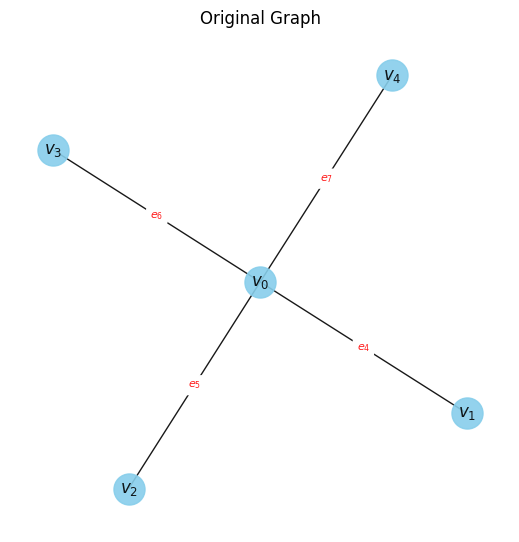

 - Graph with 5 vertices and 8 edges.
 - Features dimensions: [11, 4]
 - There are 0 isolated nodes.



In [52]:
dataset = loader.load()
describe_data(dataset)

## Loading and Applying the Lifting

In this section we will instantiate the lifting we want to apply to the data. 

The lifting is applied. Observe that the threshold determining when two atoms are close is defined in this config file under *threshold_distance* parameter.

In [53]:
# Define transformation type and id
transform_type = "liftings"
# If the transform is a topological lifting, it should include both the type of the lifting and the identifier
transform_id = "graph2combinatorial/ring_close_atoms_lifting"

# Read yaml file
transform_config = {
    "lifting": load_transform_config(transform_type, transform_id)
    # other transforms (e.g. data manipulations, feature liftings) can be added here
}


Transform configuration for graph2combinatorial/ring_close_atoms_lifting:

{'transform_type': 'lifting',
 'transform_name': 'CombinatorialRingCloseAtomsLifting',
 'max_cell_length': None,
 'preserve_edge_attr': True,
 'feature_lifting': 'ProjectionSum',
 'threshold_distance': 1.5}


We than apply the transform via our `PreProcesor`:

In [54]:
reduced_dataset = dataset[:1000]

Transform parameters are the same, using existing data_dir: /home/bmiquel/Documents/Projects/Topo/challenge-icml-2024/datasets/graph/QM9/QM9/lifting/53526194

Dataset only contains 1 sample:


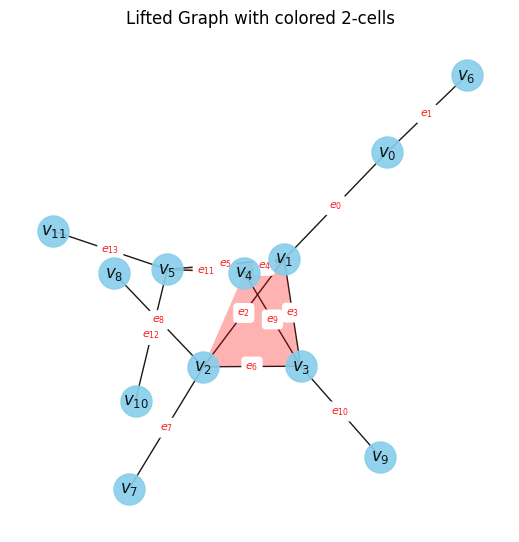

 - Hypergraph with 12 vertices and 16 hyperedges.
 - The nodes have feature dimensions 11.
 - The hyperedges have feature dimensions 11.



In [55]:
lifted_dataset = PreProcessor(reduced_dataset, transform_config, loader.data_dir)
describe_data(lifted_dataset)

## Create and Run a Combinatorial NN Model

In this section a simple model is created to test that the used lifting works as intended. In this case the model uses the `x_0`, `x_1`, `x_2` which are the features of the nodes, edges and cells respectively. 

In QM9 dataset, there are 11 different features. That has been modified in the *dataset_config* file updating the correct number of features.

It also uses the `adjacency_0`, `adjacency_1`, `adjacency_2`, `incidence_1` and `incidence_2` matrices so the lifting should make sure to add them to the data.

In [56]:
from modules.models.combinatorial.hmc import HMCModel

model_type = "combinatorial"
model_id = "hmc"
model_config = load_model_config(model_type, model_id)

model = HMCModel(model_config, dataset_config)


Model configuration for combinatorial HMC:

{'in_channels': None,
 'hidden_channels': 32,
 'out_channels': None,
 'n_layers': 2,
 'negative_slope': 0.2}


In [57]:
y_hat = model(lifted_dataset.get(0))

If everything is correct the cell above should execute without errors. 